In [1]:
%matplotlib inline
import readdy._internal.readdybinding.common as rdycmn
rdycmn.register_blosc_hdf5_plugin()

import h5py

import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator, CV, get_dense_params

from scipy.integrate import odeint
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from pathos.multiprocessing import Pool
from sklearn.model_selection import KFold
import itertools

# CV scoring

In [4]:
with h5py.File("../slightly_more_complicated_small_box_1000000000.h5") as f:
    config = pat.TrajectoryConfig(f)
    counts = f["readdy/observables/n_particles/data"][:500000].astype(np.double)
    
with h5py.File("../slightly_more_complicated_small_box_2_500000.h5") as f:
    config_test = pat.TrajectoryConfig(f)
    counts_test = f["readdy/observables/n_particles/data"][:500000].astype(np.double)

traj = pat.Trajectory.from_counts(config, counts)
traj.update()

test_traj = pat.Trajectory.from_counts(config_test, counts_test)
test_traj.update()

bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)

max counts = 10.0, min nonzero counts = 1.0
max counts = 7.0, min nonzero counts = 1.0


In [21]:
right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
right_rates = np.array([0.,0.,0.,0.])
alphas = np.linspace(0, .05, num=128)
l1_ratios = np.array([1.0])
scale = 1. / (2. * traj.n_time_steps)
cv = CV(traj, bfc, scale, alphas, l1_ratios, 5, right_rates, mode='full_cross_traj', verbose=False, test_traj=test_traj)
cv.fit()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [22]:
xs = []
ys = []
for r in cv.result:
    if len(r['scores']) > 0:
        xs.append(r['alpha'])
        ys.append(r['scores'][0])
xs = np.array(xs)
ys = np.array(ys)
sorts = np.argsort(xs)
xs = xs[sorts]
ys = ys[sorts]

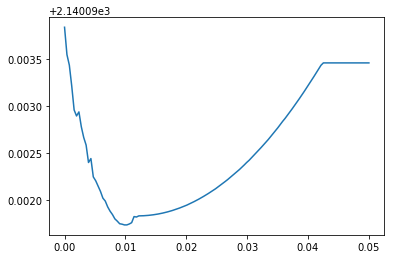

In [24]:
plt.plot(xs, -ys)

In [25]:
best_alpha = xs[np.argmax(ys)]

In [28]:
est = ReaDDyElasticNetEstimator(traj, bfc, scale, 
                                alpha=best_alpha, l1_ratio=1.0, init_xi=right_rates, 
                                verbose=True, approx_jac=False, options={'ftol': 1e-12})
est.fit(range(0, traj.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)
right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])

optimization problem did exit successfully (alpha=0.00984251968504, lambda=1.0)!
status 0: Optimization terminated successfully.
4 / 15000 iterations
coefficients=[  1.03593213e-03   6.94757700e-04   0.00000000e+00   3.50290003e-18]


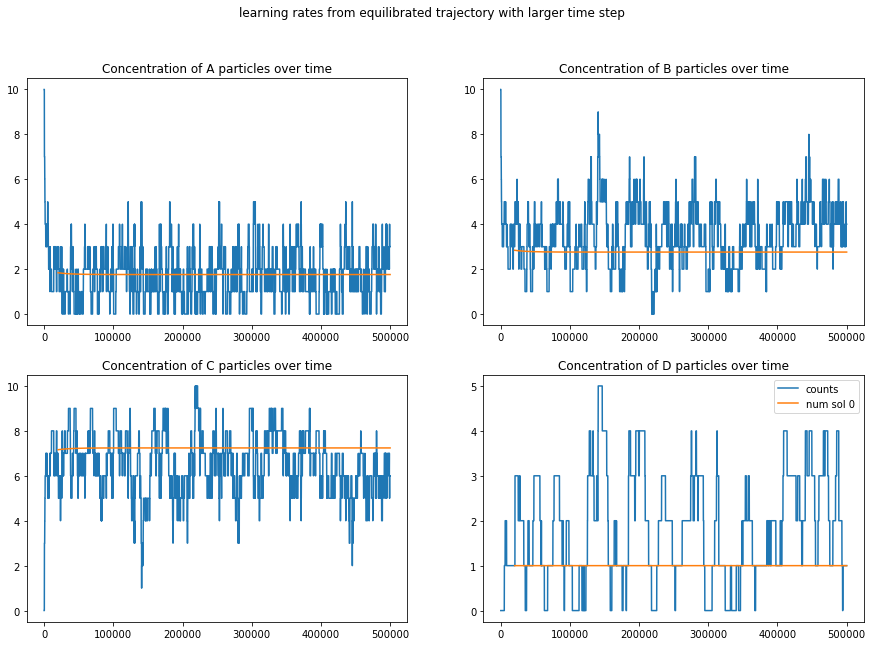

In [29]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
offset = 20000
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, traj.counts[offset], np.arange(0, traj.n_time_steps*traj.time_step, traj.time_step)))
num_solns[0] = num_solns[0][offset:]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(offset, offset+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

# more complicated small box

In [2]:
test_traj = pat.Trajectory.from_file_name("../generate/simple_trajectory_3.h5")
test_traj.update()

max counts = 9000.0, min nonzero counts = 1.0


In [3]:
with h5py.File("../slightly_more_complicated_small_box_1000000000.h5") as f:
    config = pat.TrajectoryConfig(f)
    counts = f["readdy/observables/n_particles/data"][:5000000].astype(np.double)

traj = pat.Trajectory.from_counts(config, counts)
traj.update()

bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)

max counts = 10.0, min nonzero counts = 1.0


In [4]:
right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=16)
l1_ratios = np.linspace(0, 1, num=5)
scale = 1. / (2. * traj.n_species * traj.n_time_steps)
cv = CV(traj, bfc, scale, alphas, l1_ratios, 5, right_rates, mode='k_fold', verbose=False, test_traj=test_traj)
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if r['scores'] and len(r['scores']) > 0 and np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

NameError: name 'best_alpha' is not defined

In [26]:
best_score = np.mean(cv.result[0]['scores'])
best_alpha, best_l1 = cv.result[0]['alpha'], cv.result[0]['l1_ratio']
for r in cv.result:
    if r['scores'] and len(r['scores']) > 0 and np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']

In [25]:
print(best_score)
np.mean(cv.result[4]['scores'])

-33839.178477


-33839.178477025707

# todo:
- plot scores
- redo with equilibrated test traj

In [27]:
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

best alpha=66.6666666667, best l1_ratio=0.25 with score=-33839.178477


In [29]:
# mooooooore data
coeffs = []
right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
print("initial xi: %s" % right_rates)
for factor in range(0,5):
    with h5py.File("../slightly_more_complicated_small_box_1000000000.h5") as f:
        config = pat.TrajectoryConfig(f)
        counts = f["readdy/observables/n_particles/data"][:1000000*(1+2*factor)].astype(np.double)
    tmptraj = pat.Trajectory.from_counts(config, counts)
    tmptraj.update()

    est = ReaDDyElasticNetEstimator(tmptraj, bfc, scale, 
                                    alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, 
                                    verbose=True, approx_jac=False, options={'ftol': 1e-12})
    est.fit(range(0, tmptraj.n_time_steps))
    coeffs.append(est.coefficients_)
    print("coefficients=%s (n time steps = %s)" % (est.coefficients_, 10000000*(1+2*factor)))

initial xi: [  1.96008738e-06   9.94587054e-03   1.00520362e-02   9.84303477e-03]
max counts = 10.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=66.6666666667, lambda=0.25)!
status 0: Optimization terminated successfully.
3 / 15000 iterations
coefficients=[  0.00000000e+00   5.57041220e-15   0.00000000e+00   0.00000000e+00] (n time steps = 10000000)
max counts = 10.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=66.6666666667, lambda=0.25)!
status 0: Optimization terminated successfully.
3 / 15000 iterations
coefficients=[  0.00000000e+00   4.28867480e-14   0.00000000e+00   0.00000000e+00] (n time steps = 30000000)
max counts = 10.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=66.6666666667, lambda=0.25)!
status 0: Optimization terminated successfully.
3 / 15000 iterations
coefficients=[ 0.  0.  0.  0.] (n time steps = 50000000)
max counts = 10.0, min nonzero counts = 1.0
optimization problem di

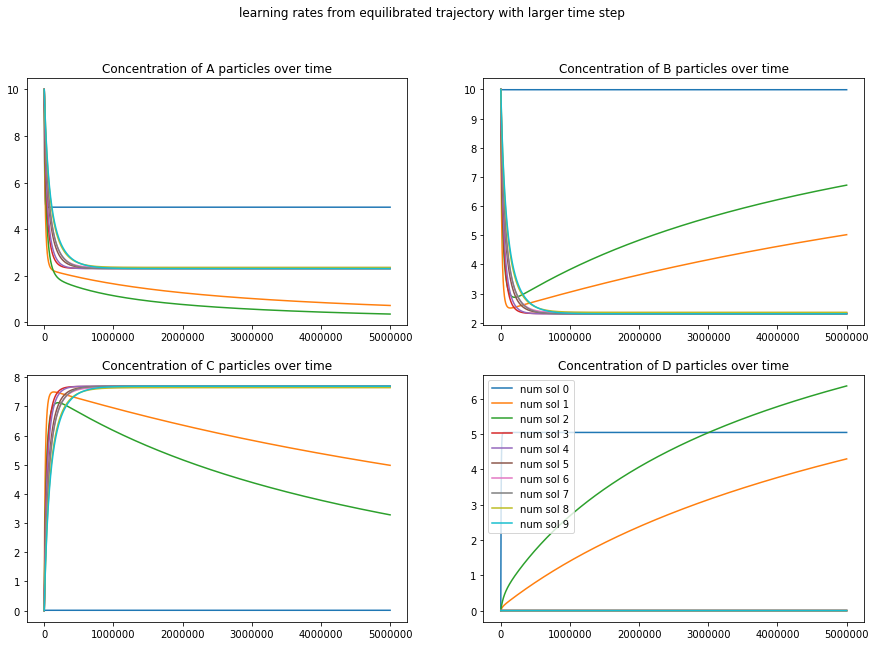

In [19]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
offset = 0
coefficients = coeffs
coefficients.insert(0, np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03]))
for coeffs in coefficients:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, traj.counts[offset], np.arange(0, traj.n_time_steps*traj.time_step, traj.time_step)))
num_solns[0] = num_solns[0][offset:]
for i in range(traj.n_species):
    # axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(offset, offset+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

In [21]:
traj = pat.Trajectory("../slightly_more_complicated_small_box.h5")
traj.update()
# scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
# right_rates = np.array([0]*bfc.n_basis_functions)
print("initial xi: %s" % right_rates)
est = ReaDDyElasticNetEstimator(traj, bfc, scale, 
                                alpha=0, l1_ratio=best_l1, init_xi=right_rates, 
                                verbose=True, approx_jac=False, options={'ftol': 1e-12})
est.fit(range(0, traj.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

max counts = 10.0, min nonzero counts = 1.0
initial xi: [  1.96008738e-06   9.94587054e-03   1.00520362e-02   9.84303477e-03]
optimization problem did exit successfully (alpha=0, lambda=0.5)!
status 0: Optimization terminated successfully.
7 / 15000 iterations
coefficients=[  5.32162963e-05   4.08211238e-05   7.01104759e-05   0.00000000e+00]


max counts = 9000.0, min nonzero counts = 1.0


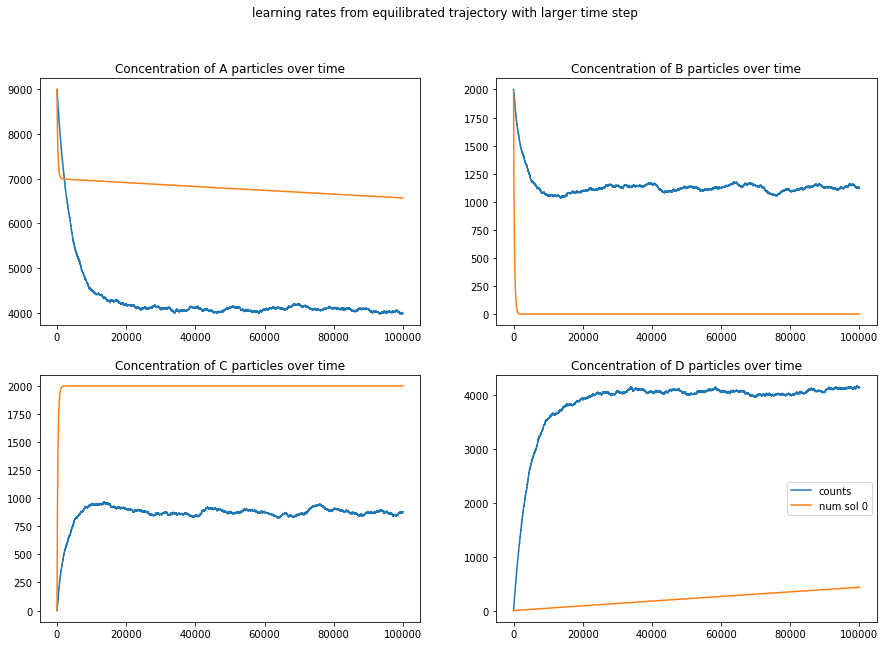

In [18]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
offset = 20000
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, traj.counts[offset], np.arange(0, traj.n_time_steps*traj.time_step, traj.time_step)))
num_solns[0] = num_solns[0][offset:]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(offset, offset+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## more ambiguity

In [ ]:
traj3 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj3.counts = traj3.counts[20000:]
traj3.counts = traj3.counts.repeat(10, axis=0)
traj3.time_step = traj3.time_step / 10.
traj3.update()

bfc = BasisFunctionConfiguration(n_species=traj3.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

In [ ]:
old_counts = np.copy(traj3.counts)

traj3.counts = traj3.counts[:20000]
traj3.update()

right_rates = np.array([1.96008738e-06,0,0,0,9.94587054e-03,0,0,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj3.n_species * traj3.n_time_steps)
cv = CV(traj3, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj3.counts = old_counts
traj3.update()

In [ ]:
est = ReaDDyElasticNetEstimator(traj3, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj3.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## even more ambiguity and wrong initial conditions

In [ ]:
traj3 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj3.counts = traj3.counts[20000:]
traj3.counts = traj3.counts.repeat(10, axis=0)
traj3.time_step = traj3.time_step / 10.
traj3.update()

bfc = BasisFunctionConfiguration(n_species=traj3.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

old_counts = np.copy(traj3.counts)

traj3.counts = traj3.counts[:20000]
traj3.update()

right_rates = np.array([1e-3]*bfc.n_basis_functions)
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj3.n_species * traj3.n_time_steps)
cv = CV(traj3, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj3.counts = old_counts
traj3.update()

est = ReaDDyElasticNetEstimator(traj3, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj3.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## maybe the derivative isn't right because it only does finite differences

## fit dense solution by least squares w sparse matrices and coupling conditions

In [11]:
from scipy.optimize.optimize import approx_fprime as fprime_helper
import analyze_tools.opt as opt

In [22]:
alpha = 140
l1_ratio = .5
large_theta = np.array([f(traj.counts) for f in bfc.functions])
large_theta = np.ascontiguousarray(np.transpose(large_theta, axes=(1, 0, 2)))
expected = traj.dcounts_dt
scale = 1. / (2. * traj.n_species * traj.n_time_steps)
f = lambda x: opt.elastic_net_objective_fun(x, alpha, l1_ratio, large_theta, expected, scale)
fprime = lambda x: fprime_helper(x, f, 1e-8)
fprime2 = lambda x: opt.elastic_net_objective_fun_jac(x, alpha, l1_ratio, large_theta, expected, scale)

In [13]:
print(fprime(np.array([1, 1, 1, 1])))
print(fprime2(np.array([1, 1, 1, 1])))

[ 164.60916186  147.52154129  142.17904436  141.25505459]
[ 164.7995659   147.45580883  142.12722874  141.10510969]


In [14]:
xa = np.linspace(0, .5, num=200)
y = np.array([fprime(np.array([x, 1e-3, 1e-3, 1e-3])) for x in xa])

In [23]:
xa = np.linspace(0, .5, num=200)
y2 = np.array([fprime2(np.array([x, 1e-3, 1e-3, 1e-3])) for x in xa])

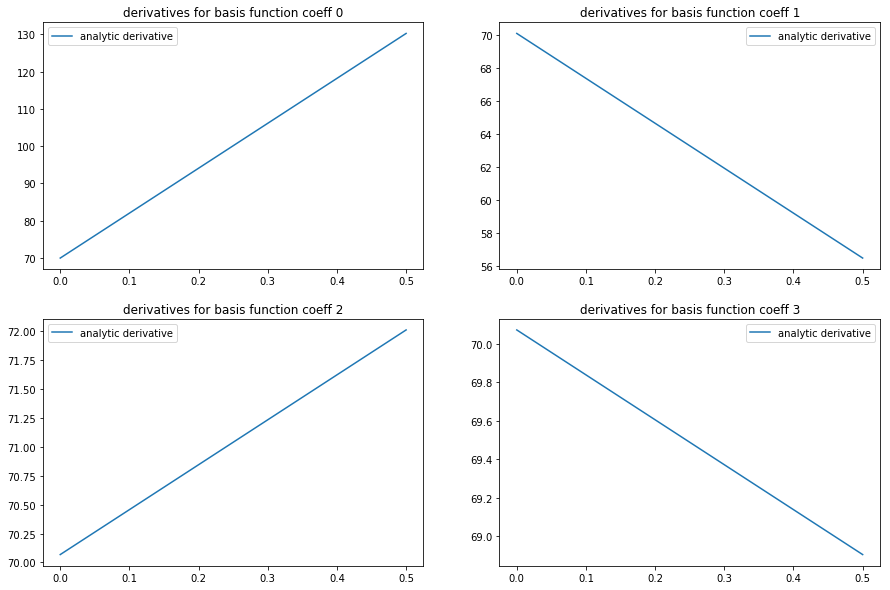

In [24]:
from itertools import chain
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = list(chain(*axes))

for rate in range(bfc.n_basis_functions):
    # axes[rate].plot(xa, y[:,rate], label="numeric derivative")
    axes[rate].plot(xa, y2[:, rate], label="analytic derivative")
    axes[rate].set_title("derivatives for basis function coeff %s" % rate)
    axes[rate].legend()

plt.legend()
plt.show()

In [25]:
xa = np.linspace(0, 1e-6, num=20)
f = lambda x: opt.elastic_net_objective_fun(x, alpha, l1_ratio, large_theta, expected, scale)
r = max(xa)/2
y31 = np.array([f(np.array([1.96008738e-06-r+x,9.94587054e-03,1.00520362e-02,9.84303477e-03])) for x in xa])
y32 = np.array([f(np.array([1.96008738e-06,9.94587054e-03-r+x,1.00520362e-02,9.84303477e-03])) for x in xa])
y33 = np.array([f(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02-r+x,9.84303477e-03])) for x in xa])
y34 = np.array([f(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03-r+x])) for x in xa])

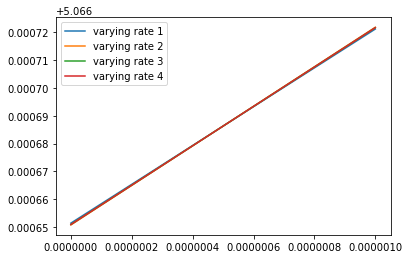

In [26]:
from itertools import chain

plt.plot(xa, y31, label="varying rate 1")
plt.plot(xa, y32, label="varying rate 2")
plt.plot(xa, y33, label="varying rate 3")
plt.plot(xa, y34, label="varying rate 4")

plt.legend()
plt.show()

In [27]:
opt.score(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05,1.64304313e-05]), large_theta, expected)

15402.597183213644

In [28]:
opt.score(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03]), large_theta, expected)

15407.254727067035

In [29]:
opt.score(np.array([0.00000000e+00, 2.63283833e-05, 6.74631349e-05, 1.19722114e-13]), large_theta, expected)

15402.597186190338

In [30]:
f = lambda x: opt.elastic_net_objective_fun(x, 0, best_l1, large_theta, expected, scale)
print("wrong 1: %s " % f(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05,1.64304313e-05])))
print("wrong 2: %s" % f(np.array([0.00000000e+00, 2.63283833e-05, 6.74631349e-05, 1.19722114e-13])))

wrong 1: 2.9654997033042907 
wrong 2: 2.9654997044505116


In [31]:
print("correct: %s" % f(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])))

correct: 2.9672934310797756


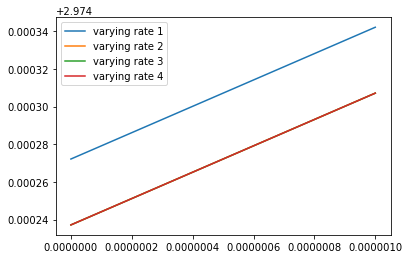

In [33]:
xa = np.linspace(0, 1e-6, num=20)
f = lambda x: opt.elastic_net_objective_fun(x, alpha, l1_ratio, large_theta, expected, scale)
r = max(xa)/2
y31 = np.array([f(np.array([0.00000000e+00+x,2.53069627e-05,8.35795089e-05,1.64304313e-05])) for x in xa])
y32 = np.array([f(np.array([0.00000000e+00,2.53069627e-05-r+x,8.35795089e-05,1.64304313e-05])) for x in xa])
y33 = np.array([f(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05-r+x,1.64304313e-05])) for x in xa])
y34 = np.array([f(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05,1.64304313e-05-r+x])) for x in xa])

plt.plot(xa, y31, label="varying rate 1")
plt.plot(xa, y32, label="varying rate 2")
plt.plot(xa, y33, label="varying rate 3")
plt.plot(xa, y34, label="varying rate 4")

plt.legend()
plt.show()